# Favorita Sales Predictions

I will be predicting the unit sales for thousands of items sold at different Favorita stores located in Ecuador. The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales. Additional files include supplementary information that may be useful in building my models.

In [65]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pyramid.arima import auto_arima


## Basic information on the training, test and submission data

I am going to start by exploring the data provided. I think the simplest model to apply may be some kind of ARIMA model. In this model I will only be considering sales data and not any of the other features. Anyway before I can do that, I need to first get a feel for the training data and that is what this section is for. 

In [3]:
sample_sub = pd.read_csv('datasets/sample_submission.csv')

sample_sub.head()

,id,unit_sales
0,125497040,0
1,125497041,0
2,125497042,0
3,125497043,0
4,125497044,0


In [4]:
train_df = pd.read_csv('datasets/train.csv')

train_df.head(20)

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
5,5,2013-01-01,25,108786,3.0,NaN
6,6,2013-01-01,25,108797,1.0,NaN
7,7,2013-01-01,25,108952,1.0,NaN
8,8,2013-01-01,25,111397,13.0,NaN
9,9,2013-01-01,25,114790,3.0,NaN


In [5]:
print("The number of entries in the training data are: %d" % len(train_df))

train_store_nbr_values = train_df.store_nbr.value_counts(dropna = False)
train_item_nbr_values = train_df.item_nbr.value_counts(dropna = False)
train_on_promo_values = train_df.onpromotion.value_counts(dropna = False)
train_date_values = train_df.date.value_counts(dropna = False)

The number of entries in the training data are: 125497040


In [6]:
print("The number of stores in the training set: %d" % len(train_store_nbr_values))
print("The number of items in the training set: %d" % len(train_item_nbr_values))
print("The first date in the training set: ", min(train_df.date))
print("The last date in the training set: ", max(train_df.date))
print("The number of unique dates in the training set: ", len(train_date_values))
print("The number of days between the first and last date: ", pd.to_datetime(max(train_df.date))-pd.to_datetime(min(train_df.date)))

The number of stores in the training set: 54
The number of items in the training set: 4036
The first date in the training set:  2013-01-01
The last date in the training set:  2017-08-15
The number of unique dates in the training set:  1684
The number of days between the first and last date:  1687 days 00:00:00


In [7]:
test_df = pd.read_csv('datasets/test.csv')

test_df.head(20)

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False
5,125497045,2017-08-16,1,105574,False
6,125497046,2017-08-16,1,105575,False
7,125497047,2017-08-16,1,105576,False
8,125497048,2017-08-16,1,105577,False
9,125497049,2017-08-16,1,105693,False


In [8]:
print("The number of entries in the test data are: %d" % len(test_df))

test_store_nbr_values = test_df.store_nbr.value_counts(dropna = False)
test_item_nbr_values = test_df.item_nbr.value_counts(dropna = False)
test_on_promo_values = test_df.onpromotion.value_counts(dropna = False)
test_date_values = test_df.date.value_counts(dropna = False)


The number of entries in the test data are: 3370464


In [9]:
print("The number of stores in the test set: %d" % len(test_store_nbr_values))
print("The number of items in the test set: %d" % len(test_item_nbr_values))
print("The first date in the test set: ", min(test_df.date))
print("The last date in the test set: ", max(test_df.date))
print("The number of unique dates in the test set: ", len(test_date_values))
print("The number of days between the first and last date: ", pd.to_datetime(max(test_df.date))-pd.to_datetime(min(test_df.date)))

The number of stores in the test set: 54
The number of items in the test set: 3901
The first date in the test set:  2017-08-16
The last date in the test set:  2017-08-31
The number of unique dates in the test set:  16
The number of days between the first and last date:  15 days 00:00:00


I've just obtained some basic information about the datasets. There are about 125 million rows in the training dataset and another 3.4 million rows in the test set. There may not be a perfect overlap between items in the training set and test set - the training set has 4036 items but the test set has just 3901. It isn't clear at this point whether all items in the test set are in the training set, however, the competition guidelines seem to indicate that this won't be the case. 
The task is to compute prediction for day to day unit sales for each of the items in the test set for a period of 16 days from the 16th of August 2017 to the 31st of August 2017. To do this I've got training data that goes back all the way to 1st Jan 2013 and carries on till the 15th of August 2017. 



## Exploring sales of a couple of items 

There is no way I can plot the sales over time for all 4036 items in the training data. However, to start I will randomly pick a couple of items and plot the sales over time. I'm doing this to see if I can spot any trends or seasonal behaviors. This may also give me a sense for how dependent future values are on past values and whether the other features account for a lot of behavior in sales or a little. 

In [10]:
train_df['date'] = pd.to_datetime(train_df['date'])

Lets pick a couple of random items to analyze ...

In [11]:
random_items = train_df.item_nbr.sample(n=20).tolist()

Important question: Is it possible to have more than 1 sales reading per day ? Or are the sales of each item aggregated on a daily basis ?


In [12]:
item0_df = train_df[train_df.item_nbr == random_items[0]]

print("The number of rows in the data for item0 are: %d" % len(item0_df))
print("The number of unique dates in the data are: %d" % len(item0_df.date.value_counts()))

item0_df.head(10)

The number of rows in the data for item0 are: 52597
The number of unique dates in the data are: 1371


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
13512794,13512794,2013-11-05,9,1239739,15.0,NaN
13561993,13561993,2013-11-06,9,1239739,10.0,NaN
13610178,13610178,2013-11-07,9,1239739,4.0,NaN
13657883,13657883,2013-11-08,9,1239739,4.0,NaN
13706394,13706394,2013-11-09,9,1239739,11.0,NaN
13758037,13758037,2013-11-10,9,1239739,27.0,NaN
13809259,13809259,2013-11-11,9,1239739,4.0,NaN
13857139,13857139,2013-11-12,9,1239739,4.0,NaN
13904638,13904638,2013-11-13,9,1239739,10.0,NaN
13951376,13951376,2013-11-14,9,1239739,14.0,NaN


Clearly the sales of each item is not aggregated on a daily basis because there are multiple stores.
So the new question: Is it possible to have more than 1 sales reading per day per store ? Or are the sales of each item aggregated on a daily basis for each store ?

In [13]:
for i in range(1,55):
    item0_store = item0_df[item0_df.store_nbr == i]
    print("The number of rows in the data for item0 in store ", i , " are: ", len(item0_store))
    print("The number of unique dates in the data for store ", i , "are: ", len(item0_store.date.value_counts()))
    print("---------------------------------------------------------------------------")

The number of rows in the data for item0 in store  1  are:  932
The number of unique dates in the data for store  1 are:  932
---------------------------------------------------------------------------
The number of rows in the data for item0 in store  2  are:  801
The number of unique dates in the data for store  2 are:  801
---------------------------------------------------------------------------
The number of rows in the data for item0 in store  3  are:  1330
The number of unique dates in the data for store  3 are:  1330
---------------------------------------------------------------------------
The number of rows in the data for item0 in store  4  are:  1202
The number of unique dates in the data for store  4 are:  1202
---------------------------------------------------------------------------
The number of rows in the data for item0 in store  5  are:  1069
The number of unique dates in the data for store  5 are:  1069
------------------------------------------------------------

Since the rows of each item in each store is exactly equal to the number of unique dates for each item and store, we can conclude that sales are indeed aggregated per day for each item in each store. This is an important result and has implications for how I will handle the data and conduct my analysis. (Offcourse I've only checked 1 random item - but seeing as the numbers are exactly equal for all 54 stores, I'm confident about my conclusion).

Now I will move on to plotting the unit sales of 20 random items in store 40 (I randomly chose the store).

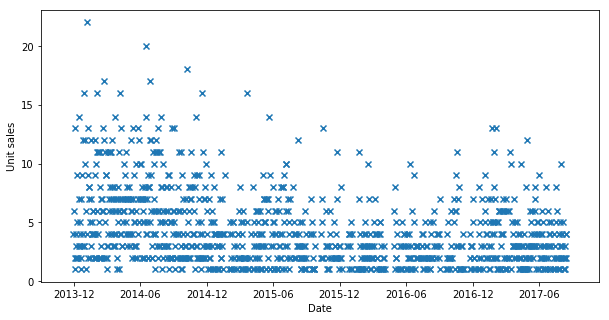

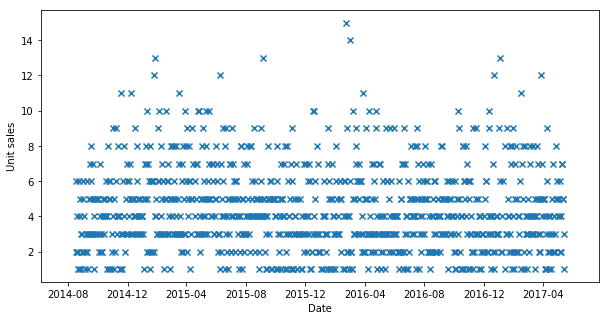

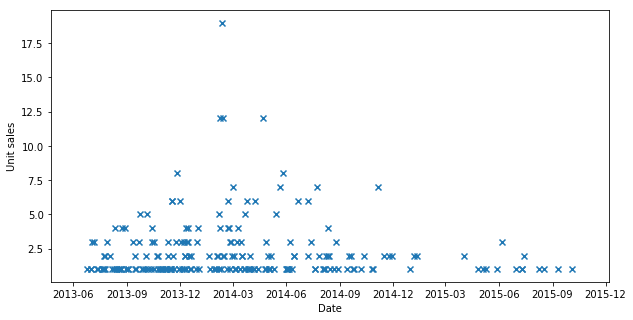

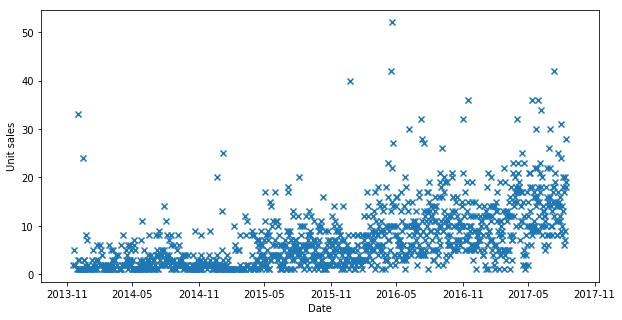

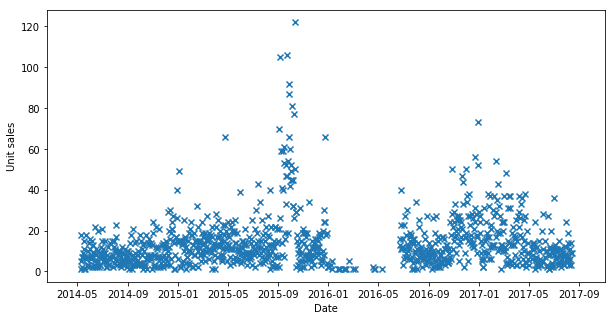

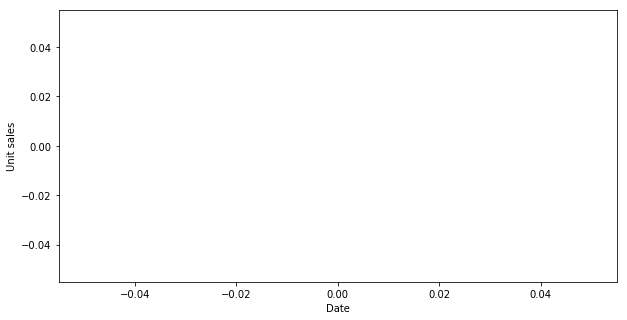

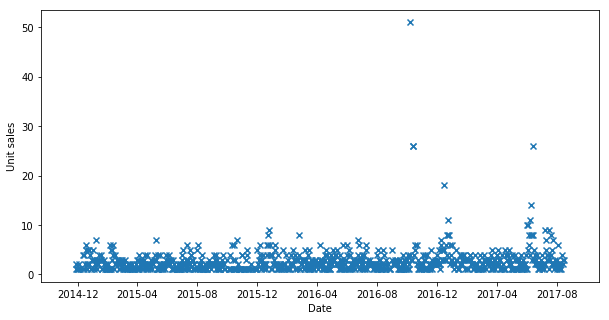

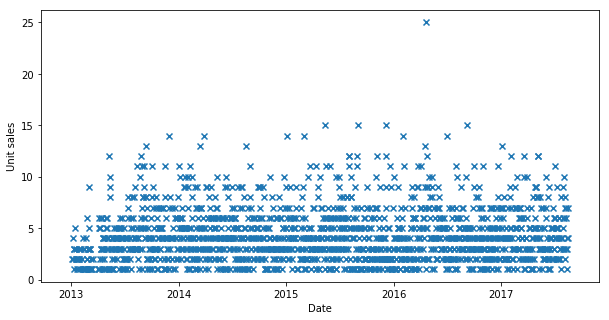

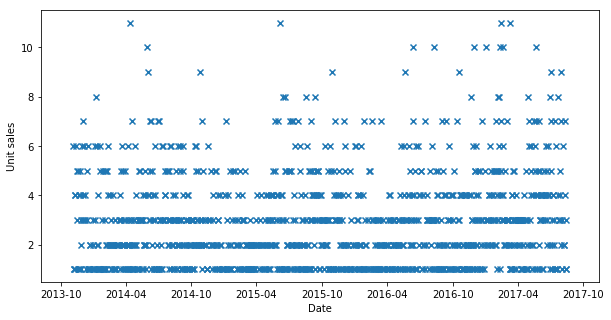

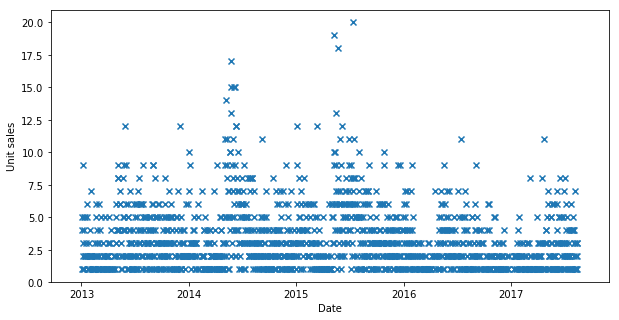

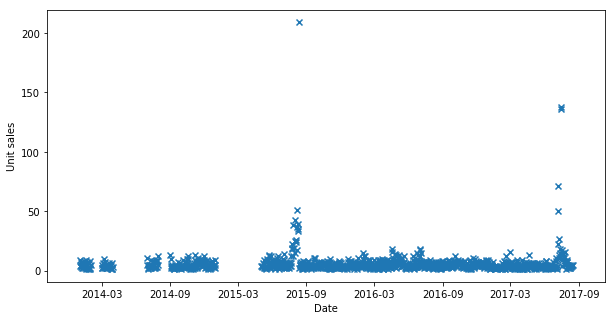

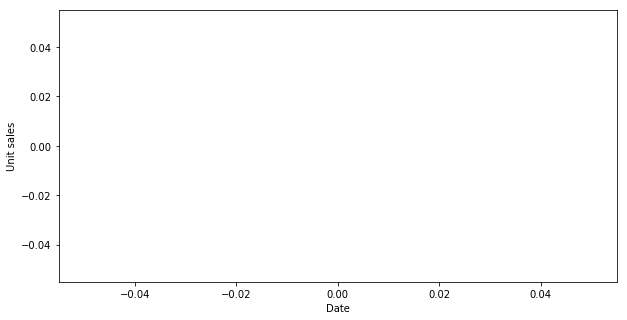

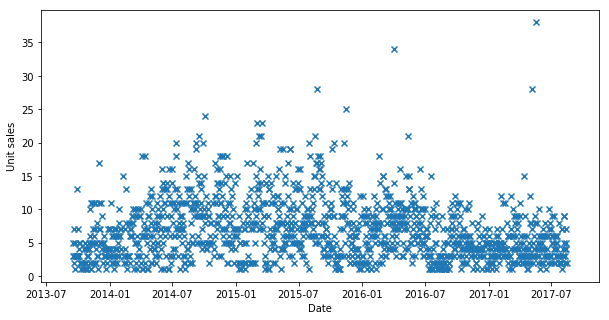

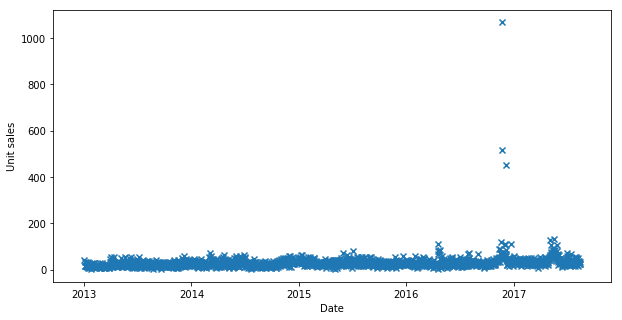

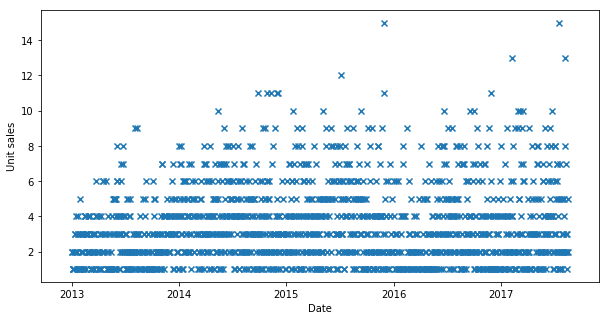

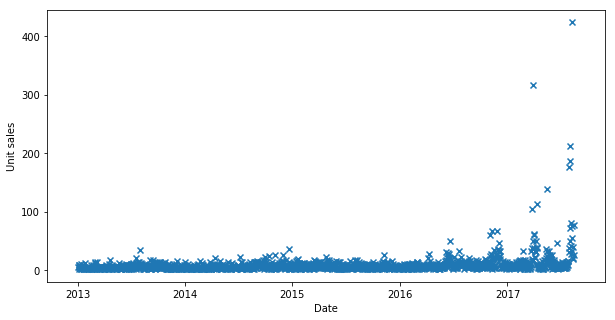

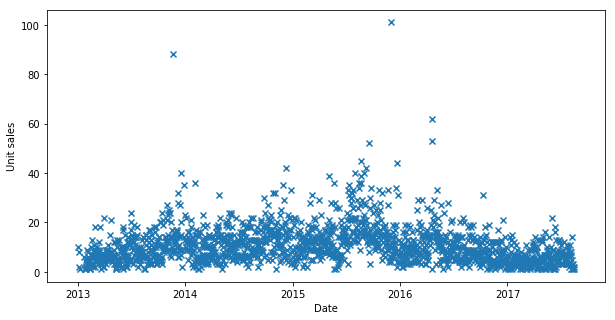

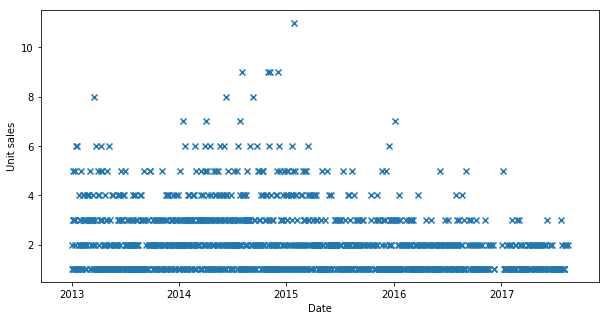

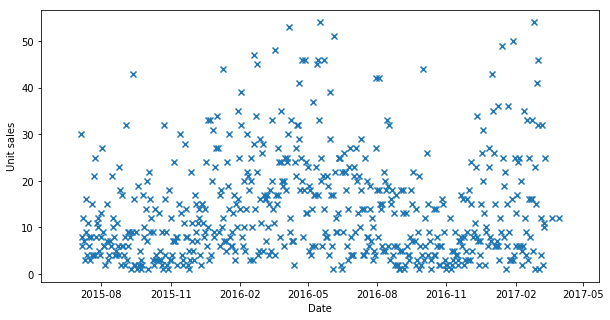

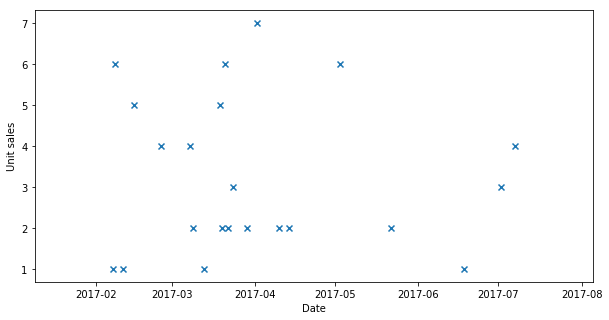

In [14]:
store40_df = train_df[train_df.store_nbr == 40]

for i in range(20):
    plt.figure(figsize=(10,5))
    itemi_df = store40_df[store40_df.item_nbr == random_items[i]]
    dates = [d.to_pydatetime() for d in itemi_df.date]
    plt.scatter(dates, y=itemi_df.unit_sales, marker='x')
    plt.ylabel('Unit sales')
    plt.xlabel('Date')

plt.show()

What is immediately apparent from the plots is that the items all have quite different sales characteristics. There are horizontal bands present on some plots because some items are sold in integer quantities e.g. 1 bag of crisps. However, other items are sold in float quantities. Some items may be popular on certain days of the year, and some items are simply not sold in that store. It is also possible that there are some missing values in the dataset - this could turn into a nuisance. It is diffcult to determine any trend or seasonality from these plots - I think day by day unit sales are just too granular for these features to become obvious. 

I can already tell that an ARIMA or ETS model by itself is not going to yield great results. Dynamic regression may yield better results - but I don't have any information (as yet) to make any real statement to this end. 

## Trying out ARIMA models on the data

I'm going to try fitting ARIMA models to items in the stores. This offcourse ignores a lot of the data I've got. However, it should make for a decent starting point. Let me start by just picking a random item and random store and fitting an ARIMA model to that courtesy of the Pyramid library.
In order to evaluate the model I'm going to split the training data into a training set and cross-validation set. The cross-val set is simply going to consist of the data for the last 2 months in the training set (reasonable small but I've done this purposely because the model only needs to predict something like 15 days ahead so there's no point in having a long duration cross-val). I want to end up with some good error metrics against which I can compare future models, and for that, this step is necessary.

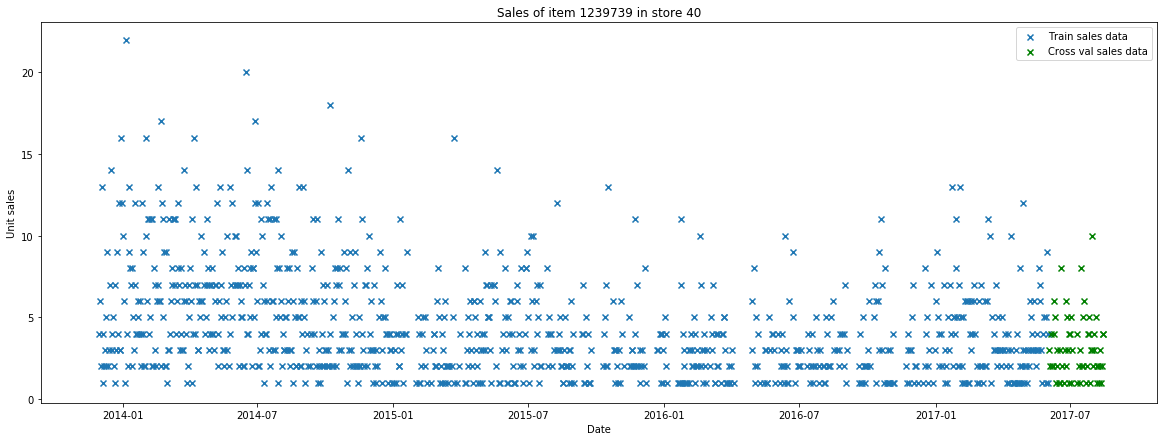

In [69]:
def item_store_dates_train_cval(item_nbr, store_nbr):
    item_df = train_df[train_df.item_nbr == random_items[0]]
    item_store_df = item_df[item_df.store_nbr == store_nbr]
    
    item_store_train = item_store_df.iloc[:-61,:]
    item_store_cval = item_store_df.iloc[-61:,:]
    
    dates_train = [d.to_pydatetime() for d in item_store_train.date]
    dates_cval = [d.to_pydatetime() for d in item_store_cval.date]
    
    return dates_train, dates_cval, item_store_train, item_store_cval

dates_train, dates_cval, item0_store40_train, item0_store40_cval = item_store_dates_train_cval(random_items[0], 40)

plt.figure(figsize=(20,7))
plt.scatter(dates_train, y=item0_store40_train.unit_sales, marker='x')
plt.scatter(dates_cval, y=item0_store40_cval.unit_sales, marker='x', color='g')
plt.title("Sales of item " + str(random_items[0]) + " in store 40")
plt.ylabel('Unit sales')
plt.xlabel('Date')
plt.legend(('Train sales data', 'Cross val sales data'), loc='upper right')
plt.show()

I'm going to assume a seasonality (m) of 7 ie. that a weekly repeating pattern may be present

In [56]:
stepwise_fit = auto_arima(item0_store40_train.unit_sales, start_p=1, start_q=1, max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=4782.090, BIC=4806.319, Fit time=2.961 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=5446.161, BIC=5465.544, Fit time=0.520 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=4779.027, BIC=4798.411, Fit time=2.149 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=4779.717, BIC=4803.947, Fit time=2.412 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=5350.064, BIC=5364.602, Fit time=0.627 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=4777.532, BIC=4801.761, Fit time=2.503 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=4780.025, BIC=4809.101, Fit time=3.548 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 7); AIC=5394.785, BIC=5414.169, Fit time=2.902 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  940
Model:             SARIMAX(0, 1, 1)x(0, 1, 2, 7)   Log Likelihood               -2383.766
Date:                           Thu, 30 Nov 2017   AIC                           4777.532
Time:                                   13:01:29   BIC                           4801.761
Sample:                                        0   HQIC                          4786.768
                                           - 940                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.358e-05      0.000      0.433      0.665      -0.000       0.000
ma.L1         -0.9750      0.009   -110.841      0.000      -0.992      -0.958
ma.S.L7       -0.9867      3.331     -0.296      0.767      -7.515       5.542
ma.S.L14      -0.0133      0.059     -0.226      0.821      -0.128       0.102
sigma2         9.3367     31.117      0.300      0.764     -51.652      70.326
===================================================================================
Ljung-Box (Q):                       39.58   Jarque-Bera (JB):               349.73
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

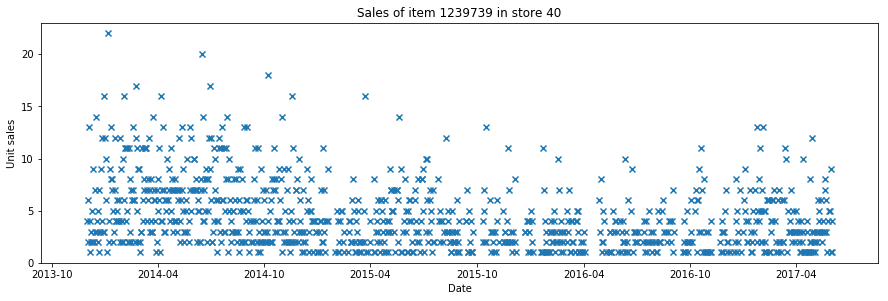

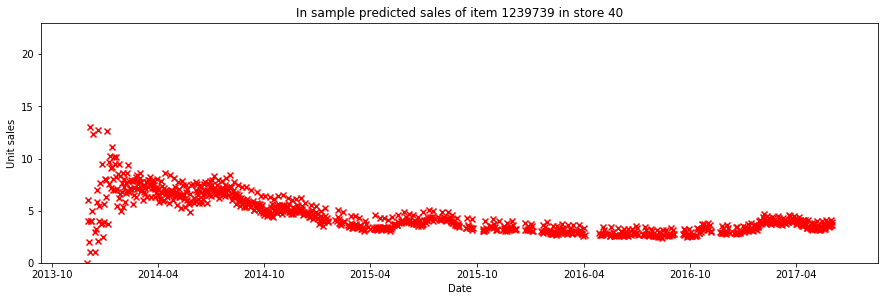

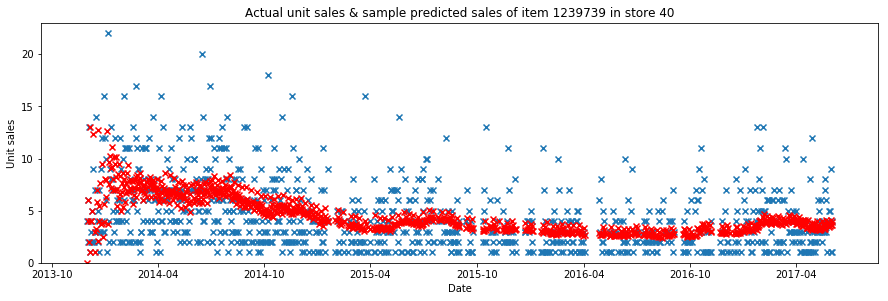

In [67]:
item0_store40_in_sample_preds = stepwise_fit.predict_in_sample()

def plot_actual_and_pred_sales(item_id, dates, actual_sales, pred_sales):
    plt.figure(figsize=(15,15))
    plt.subplot(311)
    plt.scatter(dates, y=actual_sales, marker='x')
    plt.title("Sales of item " + str(item_id) + " in store 40")
    plt.ylim([0,23])
    plt.ylabel('Unit sales')
    plt.xlabel('Date')
    plt.show()

    plt.figure(figsize=(15,15))
    plt.subplot(312)
    plt.scatter(dates, y=pred_sales, marker='x', color='r')
    plt.title("In sample predicted sales of item " + str(item_id) + " in store 40")
    plt.ylim([0,23])
    plt.ylabel('Unit sales')
    plt.xlabel('Date')
    plt.show()

    plt.figure(figsize=(15,15))
    plt.subplot(313)
    plt.scatter(dates, y=actual_sales, marker='x')
    plt.scatter(dates, y=pred_sales, marker='x', color='r')
    plt.title("Actual unit sales & sample predicted sales of item " + str(item_id) + " in store 40")
    plt.ylim([0,23])
    plt.ylabel('Unit sales')
    plt.xlabel('Date')
    plt.show()
    
plot_actual_and_pred_sales(random_items[0], dates_train, item0_store40_train.unit_sales, item0_store40_in_sample_preds)


The ARIMA model appears to have done a decent job of capturing the general trend of the series, however, it clearly isn't capturing much of the variablity in the day to day sales. Offcourse this is just the result from 1 item in 1 store ! This same model has to be run for each item in the 54 stores ie. 4036 * 54 = 217,944 times. If each run takes about 30 seconds then it will take about 1816.2 hours to run ! Or 76 days ! This just won't do ! This has just flagged that I'm going to have to take running time into consideration when doing my analysis and developing my models. 

Now I will plot the results of using this model to forecast the values for the cross-validation dates. I will then move onto model evaluation using a more formal metric.

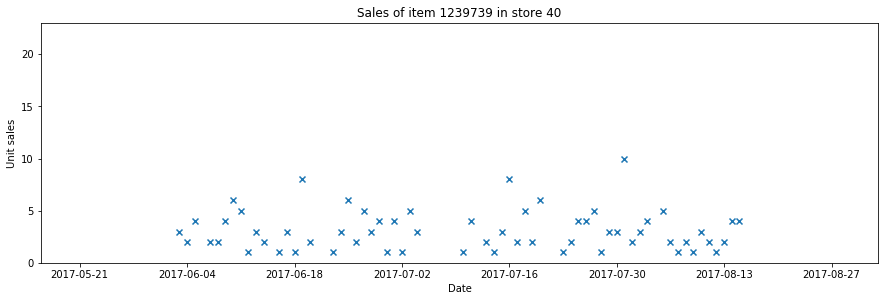

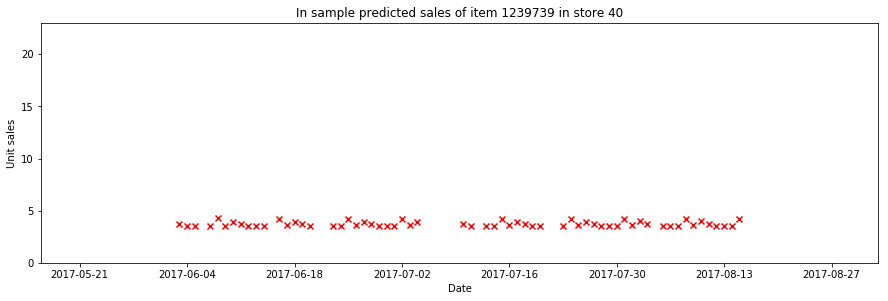

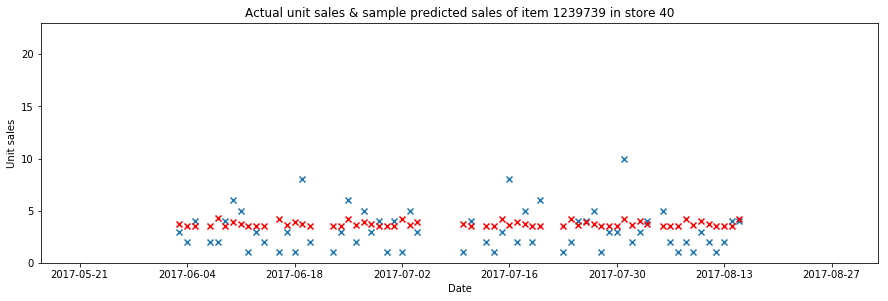

In [68]:
next_61 = stepwise_fit.predict(n_periods=61)

plot_actual_and_pred_sales(random_items[0], dates_cval, item0_store40_cval.unit_sales, next_61)

Now using RMSE as the evaluation metric ...

In [66]:
# Training set error

def rmse(actual, predicted):
    return np.sqrt((1/len(actual))*np.sum((predicted - actual)**2))
    
train_rmse = rmse(item0_store40_train.unit_sales, item0_store40_in_sample_preds)
cval_rmse = rmse(item0_store40_cval.unit_sales, next_61)

print("The RMSE for the training set: %f" % train_rmse)
print("The RMSE for the cross validation set: %f" % cval_rmse)

The RMSE for the training set: 3.213256
The RMSE for the cross validation set: 1.996275
